In [3]:
# import osmnx as ox
# import networkx as nx
import geopandas as gpd

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# from scipy.spatial.distance import pdist

area = gpd.read_file('nn_area.json')
buildings = gpd.read_file('nn_buildings_last_modified_180520_evening.json')
# nodes = gpd.read_file('nn_nodes.json')
edges = gpd.read_file('nn_roads.json')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


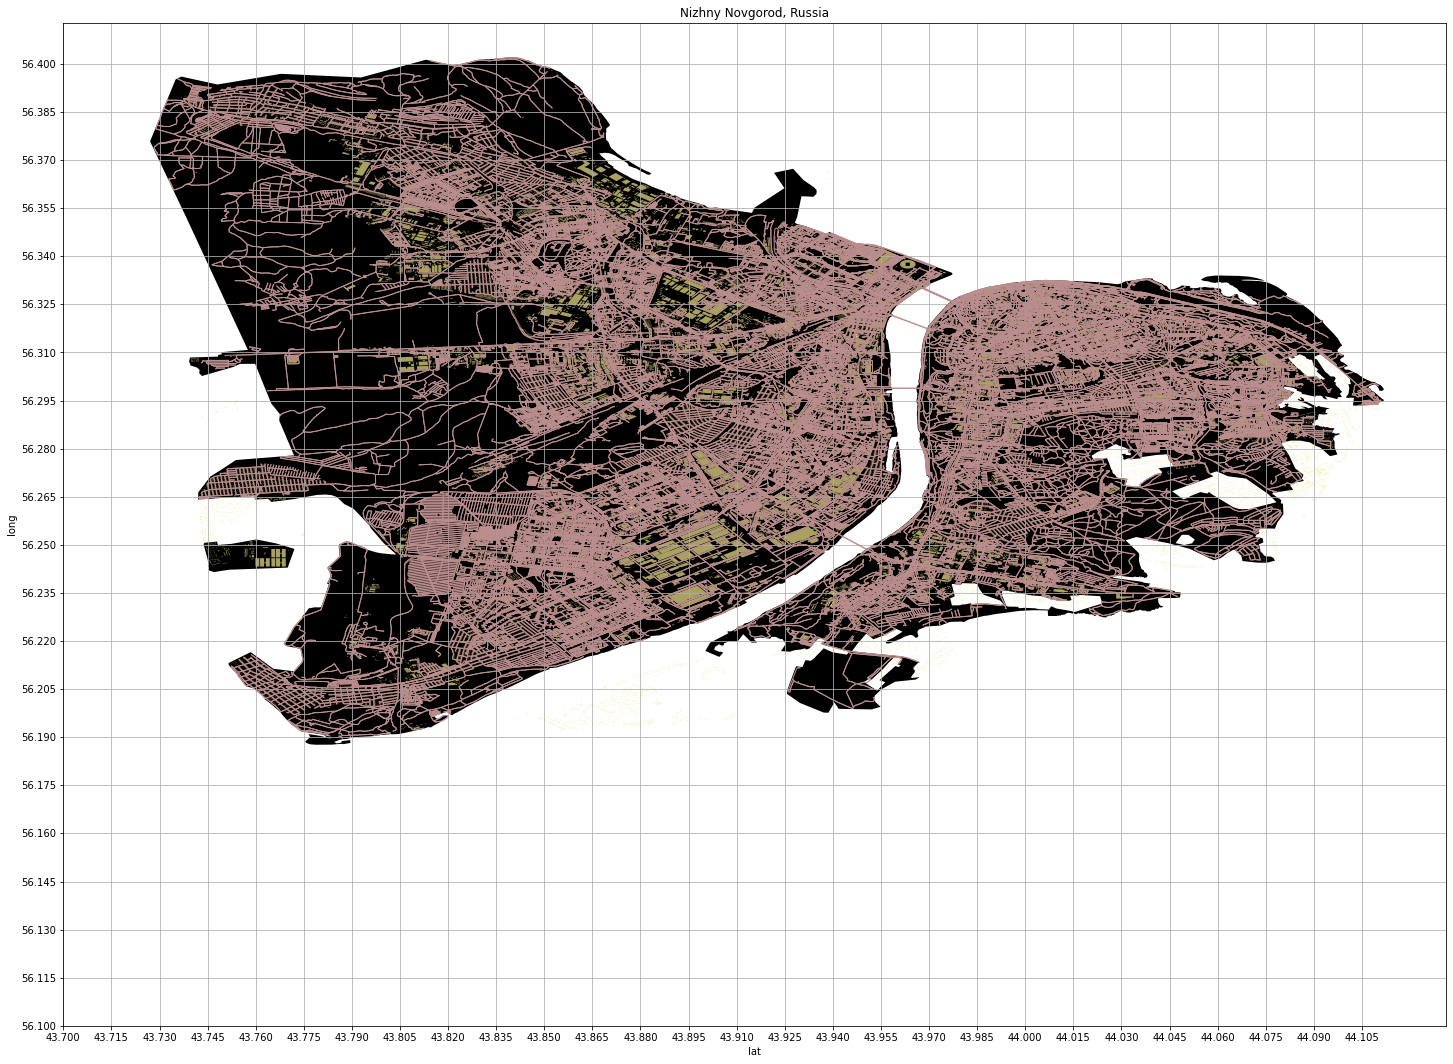

In [0]:
cell_size = 0.015
place_name = "Nizhny Novgorod, Russia"
fig, ax = plt.subplots(figsize=(20,17))
area.plot(ax=ax, facecolor='black')
edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)
plt.tight_layout()
plt.title(place_name)
plt.xlabel('lat')
plt.ylabel('long')
plt.xticks(np.arange(43.7, 44.11, cell_size)) 
plt.yticks(np.arange(56.1, 56.41, cell_size) ) 
plt.grid()
plt.show()
# buildings.loc[buildings.is_living].plot(ax=ax, facecolor='khaki', alpha=0.7)
# buildings.loc[buildings.is_working].plot(ax=ax, facecolor='g', alpha=0.7)

In [0]:
def lat_long_to_distance(lat_log_1, lat_log_2):
    '''returns distance in km'''
    lat_log_diff = lat_log_1 - lat_log_2
    meters_in_grad_lat = 111134.861111
    metters_in_grad_long = np.cos(np.deg2rad(56.2866538296335)) * 111321.377778 # NN mean latitude is 56.28... according to the given data
    long, lat = lat_log_diff
    return np.linalg.norm([meters_in_grad_lat*lat, metters_in_grad_long*long])
    

In [0]:
def get_centers(poligon_coords, decimals=6):
    long, lat = poligon_coords.centroid.xy
    coordinates = list([np.mean(long.tolist()), np.mean(lat.tolist())])
    return np.round(coordinates, decimals=decimals).tolist()

centers = buildings.geometry.apply(lambda x: get_centers(x))
buildings['building_coords'] = centers

In [0]:
print(lat_long_to_distance(np.array([43.74, 56.2]), np.array([44.1, 56.2])))
print(lat_long_to_distance(np.array([43.74, 56.1]), np.array([43.74, 56.4])))

22243.54230417054
33340.458333299684


In [0]:
print('grid cell size', lat_long_to_distance(np.array([43.75, 56.2]), np.array([43.735, 56.2])))
# print(lat_long_to_distance(np.array([43.74, 56.1]), np.array([43.74, 56.4])))

# def make_grid(cell_size=0.01):
#     longlat_grid = np.meshgrid(np.arange(43.7, 44.1, cell_size), np.arange(56.4, 56.1, -cell_size))
#     return longlat_grid

cell_size = 0.015
lat_grid = np.arange(43.7, 44.11, cell_size)
long_grid = np.arange(56.1, 56.41, cell_size)
long_grid, lat_grid

living_sector_grid = np.zeros((lat_grid.shape[0]-1, long_grid.shape[0]-1))
print(living_sector_grid.shape[0] * living_sector_grid.shape[1], living_sector_grid.shape, lat_grid.shape[0], long_grid.shape[0])

# fill in rowwise
buildings['sector'] = None
sector_counter = 0
living_sector_vector = np.zeros(540)
for long_idx in range(1, long_grid.shape[0]):
    long_left, long_right = long_grid[long_idx-1], long_grid[long_idx]
    for lat_idx in range(1, lat_grid.shape[0]):
        lat_left, lat_right = lat_grid[lat_idx-1], lat_grid[lat_idx]
        building_mask = buildings.building_coords.apply(lambda x: (lat_left<x[0]<lat_right) & (long_left<x[1]<long_right))
        buildings.loc[building_mask & (buildings['is_living'] == True), 'sector'] = sector_counter
        living_sector_grid[lat_idx-1,long_idx-1] = (buildings.loc[buildings.sector==sector_counter, 'living_number'] * 2.5).sum()
        living_sector_vector[sector_counter] = (buildings.loc[buildings.sector==sector_counter, 'living_number'] * 2.5).sum()
        sector_counter +=1

print(living_sector_grid.sum())
np.save('living_sector_grid.npy', living_sector_grid)

grid cell size 926.8142626738091
540 (27, 20) 28 21
1272925.0


In [0]:
living_sector_grid.shape

(27, 20)

# working vector

In [0]:
work_stats = {'agriculture': 14717,
              'industrial': 189166 + 753 + 10531,  # industrial, mining, water_supply
              'electricity': 26619,
              'construction': 13479,
              'trading': 65168,
              'transportation': 55064,
              'cafe': 7418,
              'office': 22001 + 22683 + 9143,  # network, finance, real_estate
              'science': 55182,
              'administration': 14673 + 72701,  # administration, government
              'education': 103242,
              'health_care': 87154,
              'culture': 16912}

In [0]:
work_type = {'greenhouse': 'agriculture',
             'hut': 'agriculture',
             'industrial': 'industrial',
             'garages': 'industrial', 
             'manufacture': 'industrial',
             'water_tower': 'industrial',
             'oil_tank': 'industrial',
             'service': 'electricity',
             'construction': 'construction',
             'retail': 'trading',
             'kiosk': 'trading',
             'supermarket': 'trading',
             'shop': 'trading',
             'hangar': 'transportation',
             'shed': 'transportation',
             'roof': 'transportation',
             'transportation': 'transportation',
             'train_station': 'transportation',
             'storage_tank': 'transportation',
             'parking': 'transportation',
             'garage': 'transportation',
             'warehouse': 'transportation',
             'carport': 'transportation',
             'cafe': 'cafe',
             'hotel': 'cafe',
             'office': 'office', 
             'commercial': 'office',
             'university': 'science',
             'Institute': 'science',
             'government': 'administration',
             'civic': 'administration',
             'fire_station': 'administration',
             'school': 'education',
             'college': 'education',
             'kindergarten': 'education',
             'hospital': 'health_care',
             'stadium': 'culture',
             'theater': 'culture',
             'church': 'culture',
             'chapel': 'culture',
             'sports_centre': 'culture',
             'synagogue': 'culture',
             'mosque': 'culture', 
             'cathedral': 'culture',
             'public': 'culture'}

In [0]:
buildings = buildings.loc[buildings.building!='collapsed']
buildings = buildings.loc[buildings.building!='temporary']
buildings = buildings.loc[buildings.building!='ruins']
buildings = buildings.loc[buildings.building!='tank']
buildings = buildings.loc[buildings.building!='abandoned']
buildings = buildings.loc[buildings.building!='checkpoint']
buildings = buildings.loc[buildings.building!='bunker']

In [0]:
work_types = buildings.loc[buildings.is_working==True, 'building'].apply(lambda x: work_type[x])
mean_work_place = pd.Series(work_stats) / work_types.value_counts()
mean_work_place = mean_work_place.apply(np.round).astype(int)
work_places = work_types.apply(lambda x: mean_work_place.loc[x])

In [0]:
with open('nn_buildings_last_modified_180520_evening.json', 'w') as f:
    f.write(buildings.to_json())

In [0]:
cell_size = 0.015
lat_grid = np.arange(43.7, 44.11, cell_size)
long_grid = np.arange(56.1, 56.41, cell_size)
long_grid, lat_grid

working_sector_grid = np.zeros((lat_grid.shape[0]-1, long_grid.shape[0]-1))
print(working_sector_grid.shape[0] * working_sector_grid.shape[1], working_sector_grid.shape, lat_grid.shape[0], long_grid.shape[0])

# fill in columnwise
buildings['sector'] = None
sector_counter = 0
working_sector_vector = np.zeros(540)
for long_idx in range(1, long_grid.shape[0]):
    long_left, long_right = long_grid[long_idx-1], long_grid[long_idx]
    for lat_idx in range(1, lat_grid.shape[0]):
        lat_left, lat_right = lat_grid[lat_idx-1], lat_grid[lat_idx]
        building_mask = buildings.building_coords.apply(lambda x: (lat_left<x[0]<lat_right) & (long_left<x[1]<long_right))
        buildings.loc[building_mask & (buildings['is_working'] == True), 'sector'] = sector_counter
        working_sector_grid[lat_idx-1,long_idx-1] = (buildings.loc[buildings.sector==sector_counter, 'work_places']).sum()
        working_sector_vector[sector_counter] = (buildings.loc[buildings.sector==sector_counter, 'work_places']).sum()
        sector_counter +=1

print(working_sector_grid.sum())
np.save('/content/drive/My Drive/diploma/course_work/working_sector_grid.npy', working_sector_grid)

540 (27, 20) 28 21
784167.0


# distance matrix calculation

In [ ]:
# distance matrix calculation
distance_matr = np.eye(living_sector_grid.shape[0] * living_sector_grid.shape[1])
distance_matr = distance_matr * grid_cell_size / 2

cell_size = 0.015
long_centers = np.arange(43.7075, 44.105, cell_size)
lat_centers = np.arange(56.1075, 56.4, cell_size)

xx, yy = np.meshgrid(long_centers, lat_centers)
sector_centers = list(zip(xx.reshape(-1), yy.reshape(-1)))

distances = pdist(sector_centers, metric=lat_long_to_distance)
triu_idxs = np.triu_indices(distance_matr.shape[0], 1)
distance_matr[triu_idxs] = distances
distance_matr[triu_idxs[1], triu_idxs[0]] = distances
np.save('sector_distance_matrix.npy', distance_matr)

# work with matrix

In [0]:
grid_cell_size = lat_long_to_distance(np.array([43.75, 56.2]), np.array([43.735, 56.2]))
living_sector_grid = np.load('living_sector_grid.npy')
working_sector_grid = np.load('working_sector_grid.npy')
distance_matr = np.load('sector_distance_matrix.npy')

In [0]:
mean_speed_between_sectors = 30000 # per hour
mean_speed_in_sectors = 5000 # per hour
time_consumption_matrix = distance_matr.copy() # / mean_speed_between_sectors
diag_idx = np.diag_indices(time_consumption_matrix.shape[0])
time_consumption_matrix[diag_idx] = time_consumption_matrix[diag_idx] / mean_speed_in_sectors
triu_idx = np.triu_indices(time_consumption_matrix.shape[0], 1)
time_consumption_matrix[triu_idx] = time_consumption_matrix[triu_idx] / mean_speed_between_sectors
time_consumption_matrix[triu_idx[1], triu_idx[0]] = time_consumption_matrix[triu_idx[1], triu_idx[0]] / mean_speed_between_sectors

In [0]:
gamma = 0.065
gravity_fun_matr = np.exp(-gamma*time_consumption_matrix)

In [0]:
living_sector_grid = np.round(living_sector_grid)
working_sector_grid = np.round(working_sector_grid)

In [0]:
def CalcDoublyConstrained(origs, dests, attr_mat, max_iter=10):
    """
    Calculates doubly constrained trip distribution for a given friction factor matrix
    origs = origins vector
    dests = destinations vector
    attr_mat = attraction matrix
    max_iter (optional) = maximum iterations, default is 10
    Returns trip table
    """
    trips1 = np.zeros((len(origs), len(origs)))
    print('Checking production, attraction balancing:')
    sum_p = origs.sum()
    sum_a = dests.sum()
    print('Production: ', sum_p)
    print('Attraction: ', sum_a)
    if sum_p != sum_a:
        print('origins and destinations do not balance, destinations will be scaled to origins!')
        dests = dests * (sum_p / sum_a)
        attr_t = dests.copy()
        prod_t = origs.copy()
    else:
        print('origins - destinations balancing OK.')
        attr_t = dests.copy()
        prod_t = origs.copy()

    for balIter in range(0, max_iter):
        for i in range(0, len(origs)):
            # max to avoid zero devision
            trips1[i, :] = np.round(origs[i] * dests * attr_mat[i, :] / max(0.000001, sum(dests * attr_mat[i, :])))

        # balancing procedure
        computed_dest = trips1.sum(0)
        computed_dest[computed_dest == 0] = 1
        dests = dests * (attr_t / computed_dest)

        computed_origs = trips1.sum(1)
        computed_origs[computed_origs == 0] = 1
        origs = origs * (prod_t / computed_origs)

    for i in range(0, len(origs)):
        trips1[i, :] = np.round(origs[i] * dests * attr_mat[i, :] / max(0.000001, sum(dests * attr_mat[i, :])))

    return trips1

In [0]:
living_sector_grid = living_sector_grid * (working_sector_grid.sum()/living_sector_grid.sum())

In [0]:
living_sector_grid = np.round(living_sector_grid)

In [0]:
# remove rounding mistakes
living_sector_grid.reshape(-1)[np.argmax(living_sector_grid)] -= living_sector_grid.sum()- working_sector_grid.sum() 

In [48]:
accuracy = dict()
for itr_num in range(40):
    trip_table = CalcDoublyConstrained(living_sector_grid.T[::-1].reshape(-1), working_sector_grid.T[::-1].reshape(-1), gravity_fun_matr, itr_num)
    accuracy[itr_num] = np.abs(living_sector_grid.sum() - trip_table.sum())

# best 26
itr_num = 26
trip_table = CalcDoublyConstrained(living_sector_grid.T[::-1].reshape(-1), working_sector_grid.T[::-1].reshape(-1), gravity_fun_matr, itr_num)

Checking production, attraction balancing:
Production:  784167.0
Attraction:  784167.0
Production, attraction balancing OK.


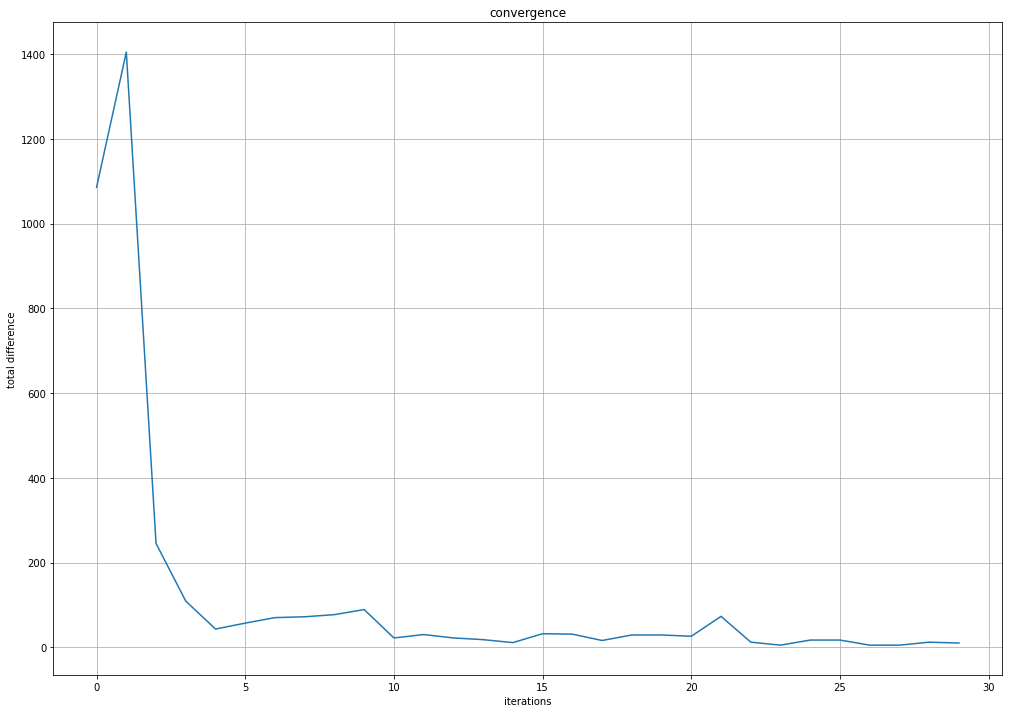

In [43]:
plt.figure(figsize=(17,12))
plt.plot(list(accuracy.keys())[:30], accuracy_values[:30])
plt.title('convergence')
plt.xlabel('iterations')
plt.ylabel('total difference')
plt.grid()
plt.show()

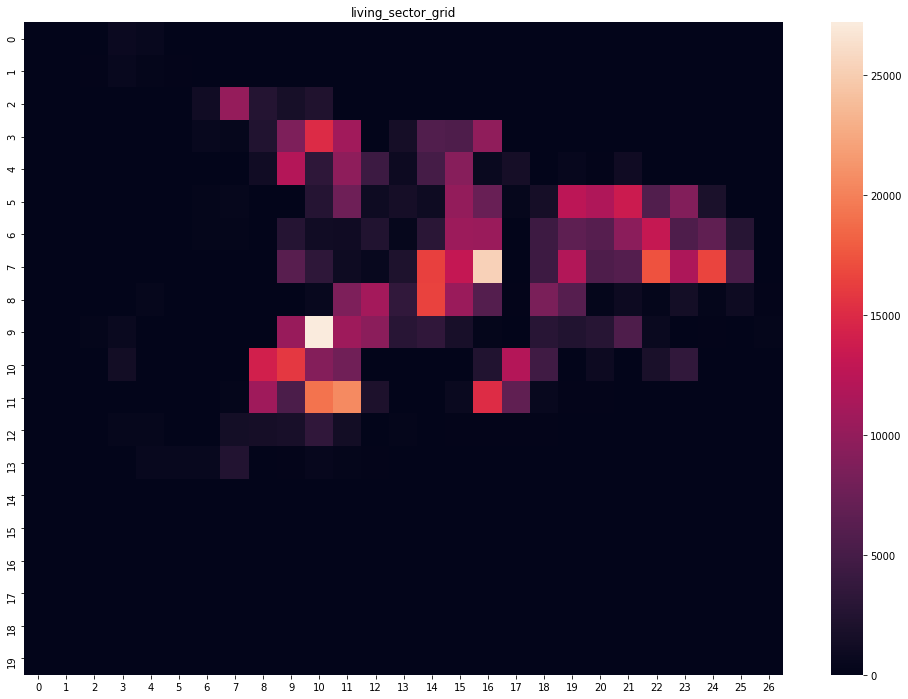

In [0]:
plt.figure(figsize=(17,12))
sns.heatmap(living_sector_grid.T[::-1])
plt.title('living_sector_grid')
plt.show()

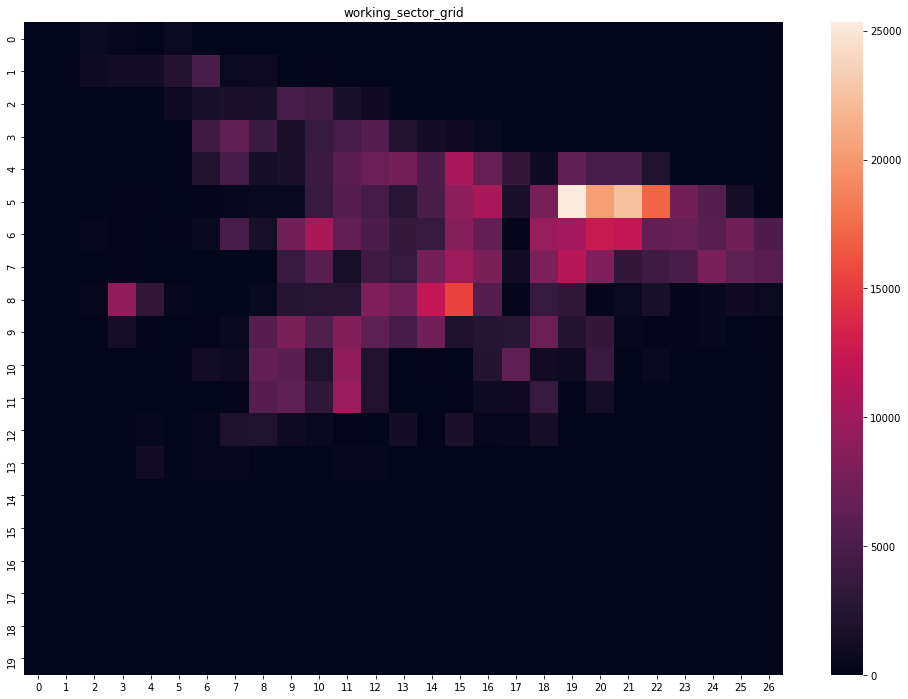

In [0]:
plt.figure(figsize=(17,12))
sns.heatmap(working_sector_grid.T[::-1])
plt.title('working_sector_grid')
plt.show()

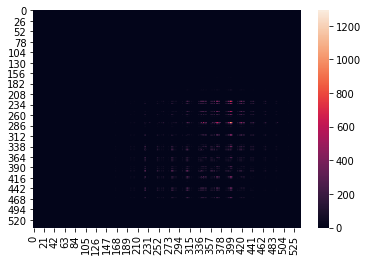

In [0]:
sns.heatmap(trip_table)
plt.show()

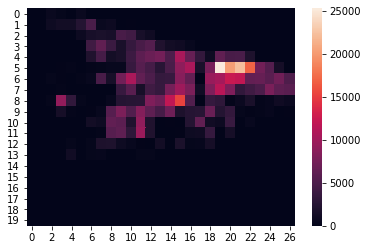

In [0]:
sns.heatmap(trip_table.sum(0).reshape((20,27)))
plt.show()

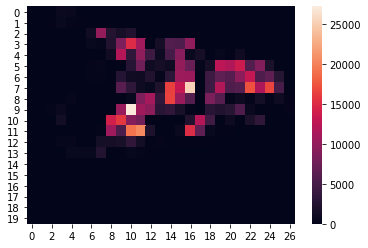

In [0]:
sns.heatmap(trip_table.sum(1).reshape((20,27)))
plt.show()

In [0]:
cell_size = 0.015
lat_centers = np.arange(43.7075, 44.105, cell_size)
long_centers = np.arange(56.1075, 56.4, cell_size)

xx, yy = np.meshgrid(lat_centers, long_centers)
sector_centers = list(zip(xx[::-1].reshape(-1), yy[::-1].reshape(-1)))

In [50]:
pd.Series(trip_table.reshape(-1)).describe()

count    291600.000000
mean          2.689204
std          17.314341
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         871.000000
dtype: float64

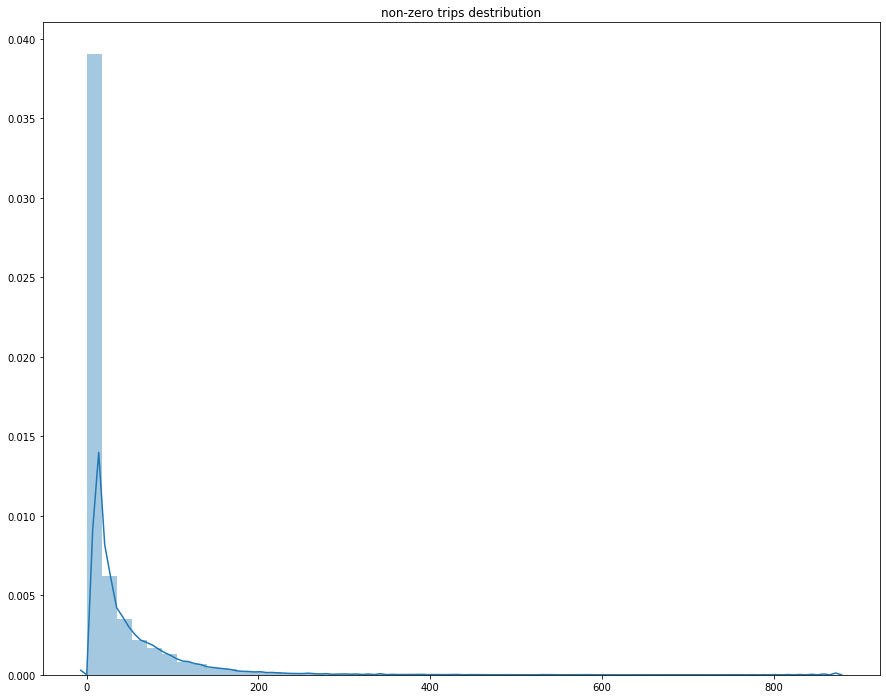

In [53]:
plt.figure(figsize=(15,12))
sns.distplot(trip_table[trip_table>0])
plt.title('non-zero trips destribution')
plt.show()

In [19]:
trip_table.sum()

784167.0000000001

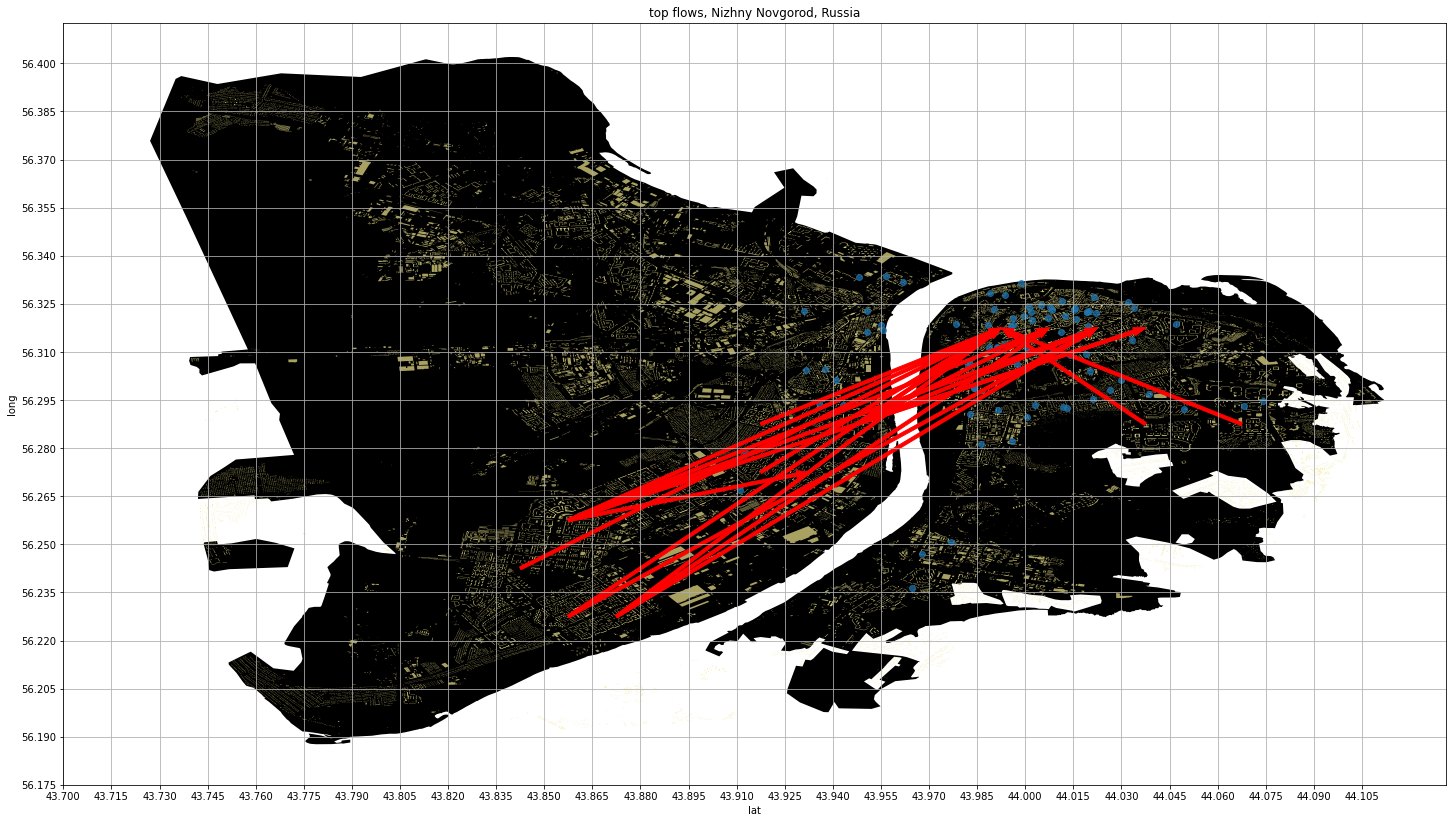

In [69]:
start_sectors, end_sectors = np.where(trip_table>0)
sectors_matrix = np.reshape(list(range(540)),(20,27))
# moovings = np.zeros(living_sector_grid.shape)

# plt.figure(figsize=(22,20))
# sns.heatmap(moovings)

place_name = "Nizhny Novgorod, Russia"
fig, ax = plt.subplots(figsize=(20,17))
area.plot(ax=ax, facecolor='black')
# edges.plot(ax=ax, linewidth=1, edgecolor='#BC8F8F')
buildings.plot(ax=ax, facecolor='khaki', alpha=0.7)

# start_node = 169
# itr_indexes = np.where(trip_table[start_node]>0)[0]
xitr, yitr = np.where(trip_table>500)
for i in range(yitr.shape[0]):
  start_dot = np.array(sector_centers)[xitr[i]]
  end_dot = np.round(np.array(sector_centers)[yitr[i]], 4)
  diff = end_dot - start_dot
  plt.arrow(start_dot[0], start_dot[1], diff[0], diff[1], length_includes_head=True, color='r', head_width=0.0025)

plt.tight_layout()
plt.title('top flows, '+place_name)
plt.xlabel('lat')
plt.ylabel('long')
plt.xticks(np.arange(43.7, 44.11, cell_size)) 
plt.yticks(np.arange(56.175, 56.41, cell_size))
plt.grid()
plt.show() 

In [0]:
trip_table.shape

(540, 540)

In [0]:
tt = pd.DataFrame(trip_table)
tt.to_excel("/content/drive/My Drive/diploma/course_work/output.xlsx")